# Creating Neural Net that finds topics in articles

We'll target the articles in Hacker News but esentially it's the same text as they are in BBC or Reuters or whatever. So it's convenient to search for a nice corpus in csv format that will do the work and we don't reinvent the wheel from scratch. Thankfully I found this dataset in Kaggle:

[Click](https://www.kaggle.com/kishanyadav/inshort-news?select=inshort_news_data-3.csv)

Esentially there are 7 big topics: technology,sports,politics,entertainment,world,automobile and science. This covers exactly the profile of Hacker News so we can proceed. Anyway, there is a free HN dataset in Big Query so I will get a sample to make final tests on it and use  every single observation from Kaggle dataset for training only.

### Retrieve test data from Big Query 

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
from google.cloud import bigquery
client = bigquery.Client('hn-model-creation')

In [3]:
pip install tensorflow-addons

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, Dropout, LSTM, GRU, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
sql = """
    SELECT text
    FROM `bigquery-public-data.hacker_news.stories`
    WHERE text IS NOT NULL and text != '' and text != 'Mind the gap.'
    LIMIT 100
"""

df_hn = client.query(sql).to_dataframe()

In [6]:
df_hn

,text
0,I&#x27;d love to get some feedback from HN. We...
1,Cauti modalitati de a face bani? Daca esti des...
2,Visit Dubai Escorts is Escorts Directory with ...
3,El hospital de El Vendrell (Tarragona) tiene u...
4,"btw i'm not a php fan, but some times i have t..."
...,...
95,Slap The Bull&#x27;s 2nd song and it&#x27;s go...
96,Aren&#x27;t there other strategies that would ...
97,Question for you all - Has anyone heard or had...
98,I&#x27;m currently working full time and spend...


### Retrieve train data, EDA and data engineering

In [7]:
df = pd.read_csv('/content/drive/MyDrive/archive/inshort_news_data-1.csv')
df.shape

(4817, 4)

There are 6 more files like this. As we said, we'll use the entire data from Kaggle for training and test with HN data we created above. Just concat all these csv files into one big pandas dataframe and we are ready to train.

In [8]:
for i in range(2, 8):
  df_train = pd.read_csv(f'/content/drive/MyDrive/archive/inshort_news_data-{i}.csv')
  df = df.append(df_train, ignore_index = True)

In [9]:
df.shape

(12120, 4)

Let's check the distribution.

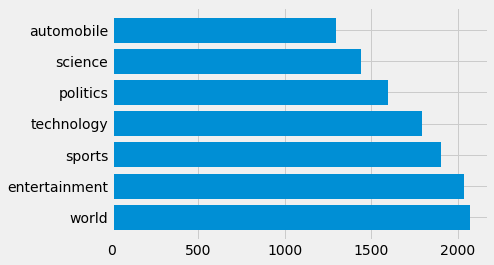

In [10]:
plt.figure(figsize=[6,4])
plt.barh(df['news_category'].value_counts().index, df['news_category'].value_counts());

It is somewhat balanced so we don't need to over or undersample for now. Anyway, we'll follow the F1 score metric closely and we'll display some confusion matrices.

In [11]:
# Constants

VOCABULARY_SIZE = 20000
MAX_NUM_WORDS = 800
EMBEDDING_DIMENSIONS = 512
BATCH_SIZE = 256
CLASS_NUM = 7
EPOCHS = 100
LEARNING_RATE = 0.0001

Few more preprocessing steps before we feed the model:

1) map the target variable to numeric


2) additional cleaning with removal of the stopwords + all lowercase

3) one-hot encode the target, so we can display the F1 Score

4) create tokens, sequences and pad and truncate them with 'post' as its required by Tensorflow

In [12]:
df['news_category'] = df['news_category'].map({'automobile': 0, 'science': 1, 'politics': 2, 'technology': 3, 'sports': 4, 'entertainment': 5, 'world': 6})

In [13]:
df['text'] = df['news_article']

In [14]:
def clean_corpus(row):
  lower = row.lower()
  cleaned_text = [w for w in lower.split(' ') if w not in stopwords.words('english')]
  cleaned_text = ' '.join(cleaned_text)
  return cleaned_text
df['text'] = df['text'].map(clean_corpus)

In [15]:
df.head(1)['text'].loc[0]

'deepmind\'s ai system \'alphafold\' recognised solution "protein folding", grand challenge biology 50 years. deepmind showed predict proteins fold 3d shapes, complex process fundamental understanding biological machinery life. alphafold predict shape proteins within width atom.'

In [16]:
df.sample(1)

,Unnamed: 0,news_headline,news_article,news_category,text
4502,4502,Chinese firm's COVID-19 vaccine is 86% effecti...,A COVID-19 vaccine developed by Chinese state-...,6,covid-19 vaccine developed chinese state-owned...


Good, now we have all the essentials and they are lower case.

In [17]:
x_train, y_train = df['text'], df['news_category']

In [18]:
# y_train = tf.one_hot(y_train, 7)

In [19]:
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer.fit_on_texts(x_train)

In [20]:
x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=MAX_NUM_WORDS, padding='post', truncating='post')

In [21]:
x_train.shape

(12120, 800)

### Training

The task is not among the most difficult ones so we don't need to stack a lot of layers. One bidirectional LSTM layer and one Dense to classify at the end should do decent work with this data.

In [22]:
lstm_simple = Sequential([
                          Embedding(VOCABULARY_SIZE, EMBEDDING_DIMENSIONS),
                          Bidirectional(LSTM(300, dropout=0.95)),
                          Dense(CLASS_NUM, activation='softmax')
])

In [23]:
# Helpers
early_stopping = EarlyStopping(monitor='val_loss', patience=8)
f1_score = tfa.metrics.F1Score(CLASS_NUM, name = 'f1_score', average = 'macro')

In [24]:
lstm_simple.compile(optimizer=RMSprop(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
history = lstm_simple.fit(x_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/100
38/38 [==============================] - 45s 1s/step - loss: 1.9333 - accuracy: 0.1723 - val_loss: 1.9576 - val_accuracy: 0.2492
Epoch 2/100
38/38 [==============================] - 40s 1s/step - loss: 1.9099 - accuracy: 0.2240 - val_loss: 1.9403 - val_accuracy: 0.2034
Epoch 3/100
38/38 [==============================] - 41s 1s/step - loss: 1.8862 - accuracy: 0.2648 - val_loss: 1.8706 - val_accuracy: 0.3601
Epoch 4/100
38/38 [==============================] - 41s 1s/step - loss: 1.8090 - accuracy: 0.3241 - val_loss: 1.7155 - val_accuracy: 0.3857
Epoch 5/100
38/38 [==============================] - 42s 1s/step - loss: 1.6681 - accuracy: 0.3487 - val_loss: 1.5512 - val_accuracy: 0.3738
Epoch 6/100
38/38 [==============================] - 42s 1s/step - loss: 1.5599 - accuracy: 0.3774 - val_loss: 1.4362 - val_accuracy: 0.4546
Epoch 7/100
38/38 [==============================] - 43s 1s/step - loss: 1.4625 - accuracy: 0.4302 - val_loss: 1.3956 - val_accuracy: 0.4629
Epoch 8/100
3

In [26]:
def plot_history(history_obj, string_representation1, string_representation2):
  plt.plot(history_obj.history[string_representation1], label = string_representation1)
  plt.plot(history_obj.history[string_representation2], label = string_representation2)
  plt.legend()
  plt.ylabel(string_representation1)
  plt.show()

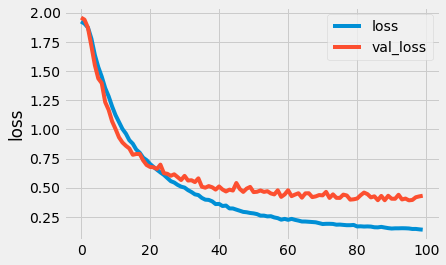

In [27]:
plot_history(history, 'loss', 'val_loss')

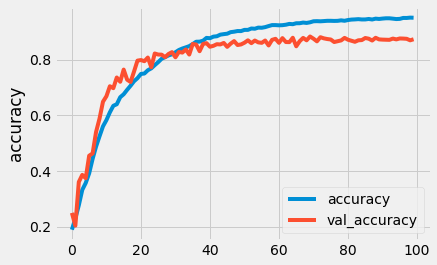

In [28]:
plot_history(history, 'accuracy', 'val_accuracy')

We weren't interrupted by the Early Stopping so that means our loss was still decreasing even at slower rates. We can continue as long as that is happening.

In [32]:
history = lstm_simple.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/20
38/38 [==============================] - 41s 1s/step - loss: 0.1465 - accuracy: 0.9491 - val_loss: 0.4341 - val_accuracy: 0.8717
Epoch 2/20
38/38 [==============================] - 41s 1s/step - loss: 0.1413 - accuracy: 0.9498 - val_loss: 0.4315 - val_accuracy: 0.8721
Epoch 3/20
38/38 [==============================] - 42s 1s/step - loss: 0.1415 - accuracy: 0.9516 - val_loss: 0.4171 - val_accuracy: 0.8696
Epoch 4/20
38/38 [==============================] - 42s 1s/step - loss: 0.1418 - accuracy: 0.9509 - val_loss: 0.3996 - val_accuracy: 0.8700
Epoch 5/20
38/38 [==============================] - 42s 1s/step - loss: 0.1375 - accuracy: 0.9535 - val_loss: 0.4768 - val_accuracy: 0.8647
Epoch 6/20
38/38 [==============================] - 43s 1s/step - loss: 0.1367 - accuracy: 0.9520 - val_loss: 0.4206 - val_accuracy: 0.8717
Epoch 7/20
38/38 [==============================] - 43s 1s/step - loss: 0.1360 - accuracy: 0.9538 - val_loss: 0.4308 - val_accuracy: 0.8738
Epoch 8/20
38/38 [==